## Setup

In [1]:
%run code.py
%matplotlib inline
time_all_start = datetime.now()

In [2]:
sig_file_name = 'data/all_el.root'
bkg_file_name = 'data/all_mu.root'

# data
# sig_tree  = 'electron_tags'
# bkg_tree  = 'muons'

# MC
sig_tree  = 'electron_mc'
bkg_tree  = 'muon_mc'

fit_verbose = 1

max_epochs = 100
# max_epochs = 20

## Create eProbabilityHT curves

In [3]:
el_eprob = uproot.open(sig_file_name)[sig_tree].array('eProbHT')
mu_eprob = uproot.open(bkg_file_name)[bkg_tree].array('eProbHT')

m_eprob = min(el_eprob.shape[0], mu_eprob.shape[0])
el_eprob = el_eprob[:m_eprob]
mu_eprob = mu_eprob[:m_eprob]
print('Using %.2g el, %.2g mu for eProbHT' % (el_eprob.shape[0], mu_eprob.shape[0]))

roc_eprob_obj = eprob_roc_generateor(el_eprob, mu_eprob)

roc_eprob = [roc_eprob_obj.tpr(), roc_eprob_obj.fpr(), 'eProbHT', 'eprob', 'black', '-']

Using 7.2e+05 el, 7.2e+05 mu for eProbHT


## Setup variables to train on

In [4]:
input_variables = OrderedDict([
    ('p',['$p$','default']),
    ('pT',['$p_{\mathrm{T}}$','default']),
    ('eta',['$\eta$','symmetric']),
    ('nTRThitsMan',['nTRT','default']),
    ('nTRTouts',['nTRT outs','default']),
    ('fHTMB',['Fraction HTMB','default']),
    ('fAr',['Fraction Ar','default']),
    ('trkOcc',['Track Occ.','default']),
    ('sumToTsumL',['$\sum\mathrm{ToT} / \sum L$','default']),
    ('lep_pT',['$p_{\mathrm{T}}^{\mathrm{lep}}$','default']),
#    ('phi',['$\phi$','default']),
])

## vars to test
# lep_pT
# phi

# PHF
# NhitsdEdx
# sumToT, sumL

# try adding eProbHT to see what else the network has learned

# all the hit_ vars, arrays of length 40 for use in RNN LSTM

# uninteresting vars - info is already included elsewhere
# nTRThits, nArhits, nXehits, nHThitsMan, nPrechitsMan

In [5]:
var_comb_dir = ''
for i,v in enumerate(input_variables.keys()):
    if i != 0: var_comb_dir += '_'
    var_comb_dir += v
plots_path = 'plots/'+var_comb_dir
models_path = 'models/'+var_comb_dir
make_path(plots_path)
make_path(models_path)

In [6]:
sig_df, bkg_df, X_train, X_test, Y_train, Y_test = create_df_tts_scale(
    sig_file_name, sig_tree,
    bkg_file_name, bkg_tree,
    list(input_variables),
    test_size=0.2,
    # test_size=0.333333,
    # sig_n=50000,
    # bkg_n=50000,
    shuffle=True,
    scale_style={i:v[1] for i,(_,v) in enumerate(input_variables.items())}
)

# val_data=None
val_data=(X_test, Y_test)

In [7]:
if False:
    print(X_train.shape)
    print(X_train[0])
    print(Y_train.shape)
    print(Y_train[0])
    print(X_train.shape[1])

input_ndimensions = X_train.shape[1]
leptons_m = Y_train.shape[0]

print("Training on m = %.2g leptons, n = %d input variables" % (leptons_m, input_ndimensions))

Training on m = 1.3e+06 leptons, n = 10 input variables


## Plot input variables

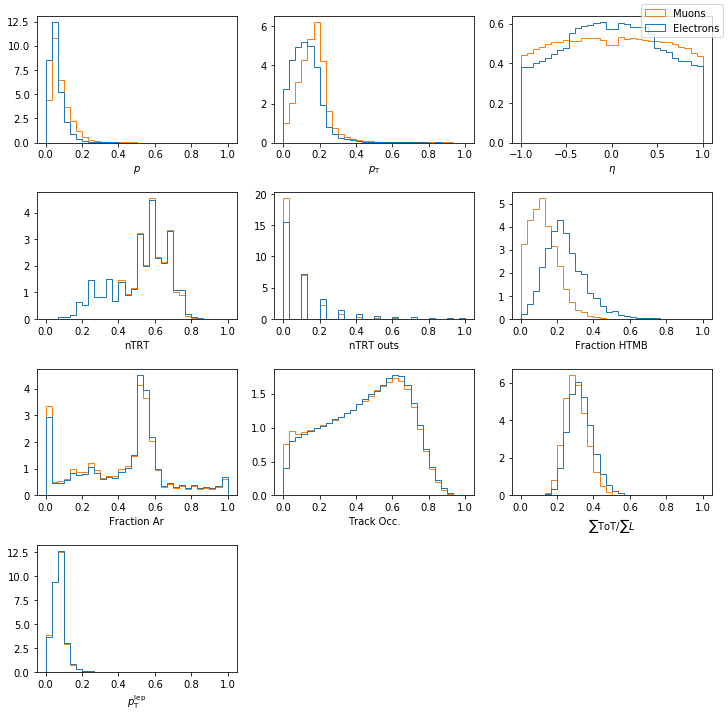

In [8]:
plot_all_input_vars(input_variables, X_train, Y_train, plots_path)

In [9]:
# plot_scale_example(sig_file_name,sig_tree,plots_path,'p','$p$ [GeV]'
# plot_scale_example(sig_file_name,sig_tree,plots_path,'pT','$p_{\mathrm{T}}$ [GeV]')

## SVM (sklearn)

In [10]:
svm_m = min(50000, Y_train.shape[0])

In [11]:
fname_svm1 = 'svm1'
train_load_svm1 = train_or_load(models_path+'/'+fname_svm1+'.pkl')

Model NOT found on disk, training


In [12]:
if train_load_svm1 == 'n':
    
    # create
    svm1 = svm.SVC(#C=1.0, #kernel='rbf', #tol=0.001, #gamma='auto',
    probability=True,
    verbose=False);

    # train
    train_start = datetime.now()

    svm1.fit(X_train[:svm_m],Y_train[:svm_m]);

    print(strfdelta(datetime.now()-train_start, "Training time: {hours} hours, {minutes} minutes, {seconds} seconds"))

    # save model to pickle
    joblib.dump(svm1, models_path+'/'+fname_svm1+'.pkl');
    
else:
    # load model from pickle
    svm1 = joblib.load(models_path+'/'+fname_svm1+'.pkl');

Training time: 0 hours, 4 minutes, 6 seconds


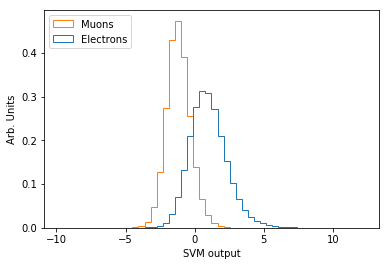

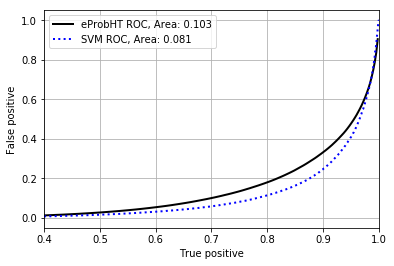

In [13]:
plot_classifier_1D_output(svm1.decision_function(X_test[Y_test>0.5]), # el
                          svm1.decision_function(X_test[Y_test<0.5]), # mu
                          'SVM', 'svm', plots_path
                          #, 'Default sklearn.svm.SVC settings'
                         )

fpr_svm1, tpr_svm1, thresholds_svm1 = roc_curve(Y_test, svm1.decision_function(X_test))
roc_svm1 = [tpr_svm1, fpr_svm1, 'SVM', 'svm', 'blue', ':']

plot_roc([roc_eprob, roc_svm1], plots_path)

# Keras / Tensorflow work

In [14]:
# fix random seed for reproducibility
np.random.seed(7)

from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model

/home/mbe9/.virtualenvs/trtml/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Default

In [15]:
fname_model_default = 'model_default'
train_load_model_default = train_or_load(models_path+'/'+fname_model_default+'.h5')

Model NOT found on disk, training


In [16]:
if train_load_model_default == 'n':
    
    # create
    model_default = Sequential()
    model_default.add(Dense(12, input_dim=input_ndimensions, activation='relu'))
    model_default.add(Dense(8, activation='relu'))
    model_default.add(Dense(1, activation='sigmoid'))

    model_default.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # train
    train_start = datetime.now()
    hist_model_default = model_default.fit(X_train, Y_train,
                                           epochs=max_epochs, batch_size=50,
                                           verbose=fit_verbose, validation_data=val_data);

    hist_dict_model_default = hist_model_default.history
    print(strfdelta(datetime.now()-train_start, "Training time: {hours} hours, {minutes} minutes, {seconds} seconds"))

    # save model to HDF5, history to pickle
    model_default.save(models_path+'/'+fname_model_default+'.h5')
   
    with open(models_path+'/'+fname_model_default+'_hist.pickle', 'wb') as handle:
        pickle.dump(hist_dict_model_default, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
else:
    # load model from HDF5, history from pickle
    model_default = load_model(models_path+'/'+fname_model_default+'.h5')
    
    with open(models_path+'/'+fname_model_default+'_hist.pickle', 'rb') as handle:
        hist_dict_model_default = pickle.load(handle)

Train on 1339322 samples, validate on 334831 samples
Epoch 1/20
1339322/1339322 [==============================] - 30s 23us/step - loss: 0.3018 - acc: 0.8798 - val_loss: 0.2666 - val_acc: 0.9037
Epoch 2/20
1339322/1339322 [==============================] - 30s 23us/step - loss: 0.2542 - acc: 0.9072 - val_loss: 0.2293 - val_acc: 0.9157
Epoch 3/20
1339322/1339322 [==============================] - 30s 23us/step - loss: 0.2151 - acc: 0.9193 - val_loss: 0.2050 - val_acc: 0.9213
Epoch 4/20
1339322/1339322 [==============================] - 30s 23us/step - loss: 0.1964 - acc: 0.9234 - val_loss: 0.1883 - val_acc: 0.9262
Epoch 5/20
1339322/1339322 [==============================] - 30s 23us/step - loss: 0.1885 - acc: 0.9257 - val_loss: 0.1853 - val_acc: 0.9274
Epoch 6/20
1339322/1339322 [==============================] - 30s 22us/step - loss: 0.1847 - acc: 0.9272 - val_loss: 0.1784 - val_acc: 0.9306
Epoch 7/20
1339322/1339322 [==============================] - 30s 23us/step - loss: 0.1824 - ac

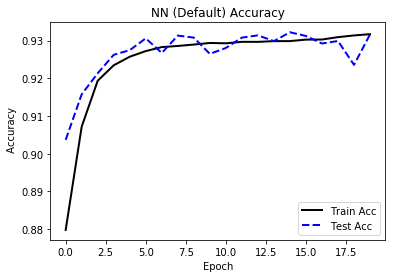

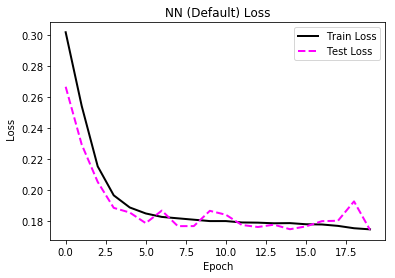

In [17]:
plot_acc_loss_vs_epoch(hist_dict_model_default, 'NN (Default)', 'nn_default', plots_path, True, False)
plot_acc_loss_vs_epoch(hist_dict_model_default, 'NN (Default)', 'nn_default', plots_path, False, True)

model_default acc: 93.16%


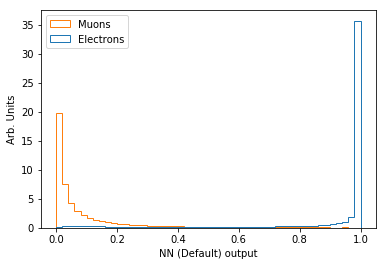

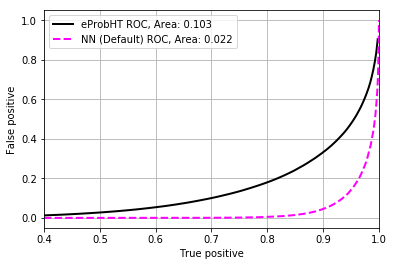

In [18]:
print("model_default %s: %.2f%%" % (model_default.metrics_names[1], model_default.evaluate(X_test,Y_test,verbose=0)[1]*100))

plot_classifier_1D_output(model_default.predict(X_test[Y_test>0.5], verbose=0), # el
                          model_default.predict(X_test[Y_test<0.5], verbose=0), # mu
                          'NN (Default)', 'nn_default', plots_path
                         )

fpr_model_default, tpr_model_default, thresholds_model_default = roc_curve(Y_test, model_default.predict(X_test, verbose=0))
roc_model_default = [tpr_model_default, fpr_model_default, 'NN (Default)', 'nn_default', 'magenta', '--']

plot_roc([roc_eprob, roc_model_default], plots_path)

### Wide

In [19]:
fname_model_wide = 'model_wide'
train_load_model_wide = train_or_load(models_path+'/'+fname_model_wide+'.h5')

Model NOT found on disk, training


In [20]:
if train_load_model_wide == 'n':
    
    # create
    model_wide = Sequential()
    model_wide.add(Dense(24, input_dim=input_ndimensions, activation='relu'))
    model_wide.add(Dense(16, activation='relu'))
    model_wide.add(Dense(1, activation='sigmoid'))

    model_wide.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # train
    train_start = datetime.now()
    hist_model_wide = model_wide.fit(X_train, Y_train,
                                           epochs=max_epochs, batch_size=50,
                                           verbose=fit_verbose, validation_data=val_data);

    hist_dict_model_wide = hist_model_wide.history
    print(strfdelta(datetime.now()-train_start, "Training time: {hours} hours, {minutes} minutes, {seconds} seconds"))

    # save model to HDF5, history to pickle
    model_wide.save(models_path+'/'+fname_model_wide+'.h5')
   
    with open(models_path+'/'+fname_model_wide+'_hist.pickle', 'wb') as handle:
        pickle.dump(hist_dict_model_wide, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
else:
    # load model from HDF5, history from pickle
    model_wide = load_model(models_path+'/'+fname_model_wide+'.h5')
    
    with open(models_path+'/'+fname_model_wide+'_hist.pickle', 'rb') as handle:
        hist_dict_model_wide = pickle.load(handle)

Train on 1339322 samples, validate on 334831 samples
Epoch 1/20
1339322/1339322 [==============================] - 30s 23us/step - loss: 0.2692 - acc: 0.8908 - val_loss: 0.2120 - val_acc: 0.9170
Epoch 2/20
1339322/1339322 [==============================] - 30s 23us/step - loss: 0.2029 - acc: 0.9195 - val_loss: 0.1882 - val_acc: 0.9266
Epoch 3/20
1339322/1339322 [==============================] - 30s 23us/step - loss: 0.1915 - acc: 0.9247 - val_loss: 0.2031 - val_acc: 0.9177
Epoch 4/20
1339322/1339322 [==============================] - 30s 23us/step - loss: 0.1869 - acc: 0.9267 - val_loss: 0.1880 - val_acc: 0.9271
Epoch 5/20
1339322/1339322 [==============================] - 30s 22us/step - loss: 0.1837 - acc: 0.9280 - val_loss: 0.1780 - val_acc: 0.9305
Epoch 6/20
1339322/1339322 [==============================] - 30s 23us/step - loss: 0.1819 - acc: 0.9288 - val_loss: 0.1761 - val_acc: 0.9324
Epoch 7/20
1339322/1339322 [==============================] - 30s 23us/step - loss: 0.1806 - ac

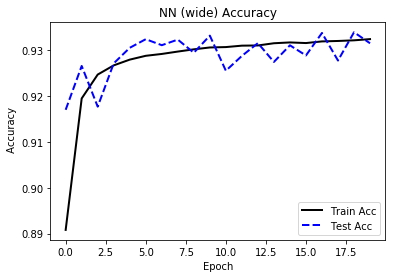

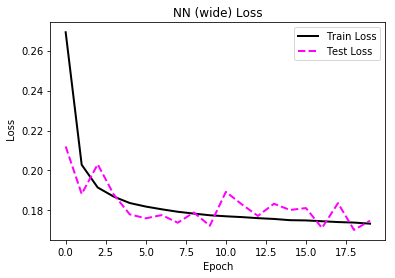

In [21]:
plot_acc_loss_vs_epoch(hist_dict_model_wide, 'NN (wide)', 'nn_wide', plots_path, True, False)
plot_acc_loss_vs_epoch(hist_dict_model_wide, 'NN (wide)', 'nn_wide', plots_path, False, True)

model_wide acc: 93.15%


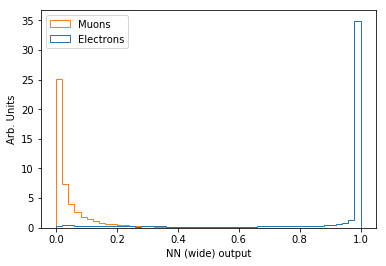

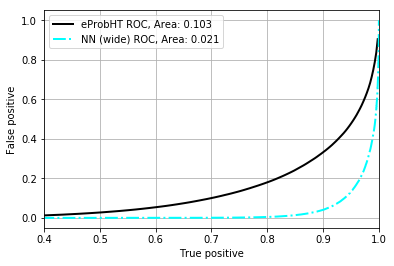

In [22]:
print("model_wide %s: %.2f%%" % (model_wide.metrics_names[1], model_wide.evaluate(X_test,Y_test,verbose=0)[1]*100))

plot_classifier_1D_output(model_wide.predict(X_test[Y_test>0.5], verbose=0), # el
                          model_wide.predict(X_test[Y_test<0.5], verbose=0), # mu
                          'NN (wide)', 'nn_wide', plots_path
                         )

fpr_model_wide, tpr_model_wide, thresholds_model_wide = roc_curve(Y_test, model_wide.predict(X_test, verbose=0))
roc_model_wide = [tpr_model_wide, fpr_model_wide, 'NN (wide)', 'nn_wide', 'cyan', '-.']

plot_roc([roc_eprob, roc_model_wide], plots_path)

### Deep

In [23]:
fname_model_deep = 'model_deep'
train_load_model_deep = train_or_load(models_path+'/'+fname_model_deep+'.h5')

Model NOT found on disk, training


In [24]:
if train_load_model_deep == 'n':
    
    # create
    model_deep = Sequential()
    model_deep.add(Dense(12, input_dim=input_ndimensions, activation='relu'))
    model_deep.add(Dense(8, activation='relu'))
    model_deep.add(Dense(8, activation='relu'))
    model_deep.add(Dense(8, activation='relu'))
    model_deep.add(Dense(8, activation='relu'))
    model_deep.add(Dense(1, activation='sigmoid'))

    model_deep.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # train
    train_start = datetime.now()
    hist_model_deep = model_deep.fit(X_train, Y_train,
                                           epochs=max_epochs, batch_size=50,
                                           verbose=fit_verbose, validation_data=val_data);

    hist_dict_model_deep = hist_model_deep.history
    print(strfdelta(datetime.now()-train_start, "Training time: {hours} hours, {minutes} minutes, {seconds} seconds"))

    # save model to HDF5, history to pickle
    model_deep.save(models_path+'/'+fname_model_deep+'.h5')
   
    with open(models_path+'/'+fname_model_deep+'_hist.pickle', 'wb') as handle:
        pickle.dump(hist_dict_model_deep, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
else:
    # load model from HDF5, history from pickle
    model_deep = load_model(models_path+'/'+fname_model_deep+'.h5')
    
    with open(models_path+'/'+fname_model_deep+'_hist.pickle', 'rb') as handle:
        hist_dict_model_deep = pickle.load(handle)

Train on 1339322 samples, validate on 334831 samples
Epoch 1/20
1339322/1339322 [==============================] - 33s 25us/step - loss: 0.2508 - acc: 0.8986 - val_loss: 0.2010 - val_acc: 0.9208
Epoch 2/20
1339322/1339322 [==============================] - 33s 25us/step - loss: 0.2041 - acc: 0.9196 - val_loss: 0.1879 - val_acc: 0.9278
Epoch 3/20
1339322/1339322 [==============================] - 33s 25us/step - loss: 0.1967 - acc: 0.9220 - val_loss: 0.1806 - val_acc: 0.9292
Epoch 4/20
1339322/1339322 [==============================] - 33s 25us/step - loss: 0.1896 - acc: 0.9248 - val_loss: 0.1875 - val_acc: 0.9264
Epoch 5/20
1339322/1339322 [==============================] - 33s 25us/step - loss: 0.1866 - acc: 0.9261 - val_loss: 0.1755 - val_acc: 0.9316
Epoch 6/20
1339322/1339322 [==============================] - 33s 25us/step - loss: 0.1847 - acc: 0.9271 - val_loss: 0.1876 - val_acc: 0.9269
Epoch 7/20
1339322/1339322 [==============================] - 33s 25us/step - loss: 0.1825 - ac

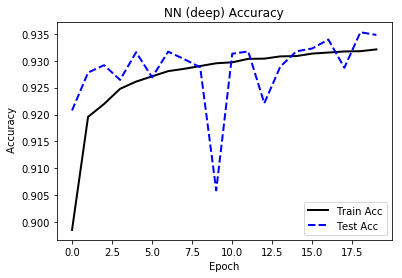

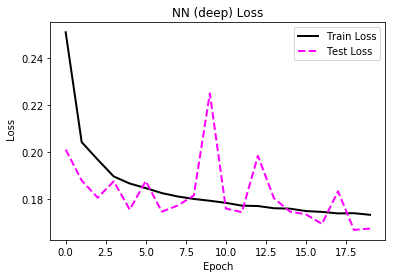

In [25]:
plot_acc_loss_vs_epoch(hist_dict_model_deep, 'NN (deep)', 'nn_deep', plots_path, True, False)
plot_acc_loss_vs_epoch(hist_dict_model_deep, 'NN (deep)', 'nn_deep', plots_path, False, True)

model_deep acc: 93.48%


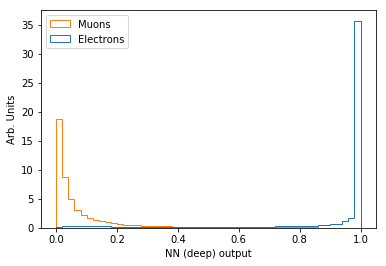

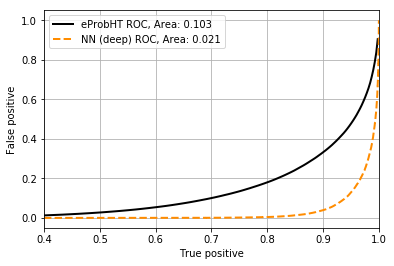

In [26]:
print("model_deep %s: %.2f%%" % (model_deep.metrics_names[1], model_deep.evaluate(X_test,Y_test,verbose=0)[1]*100))

plot_classifier_1D_output(model_deep.predict(X_test[Y_test>0.5], verbose=0), # el
                          model_deep.predict(X_test[Y_test<0.5], verbose=0), # mu
                          'NN (deep)', 'nn_deep', plots_path
                         )

fpr_model_deep, tpr_model_deep, thresholds_model_deep = roc_curve(Y_test, model_deep.predict(X_test, verbose=0))
roc_model_deep = [tpr_model_deep, fpr_model_deep, 'NN (deep)', 'nn_deep', 'darkorange', '--']

plot_roc([roc_eprob, roc_model_deep], plots_path)

### Compare all models

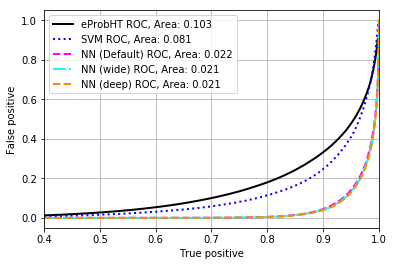

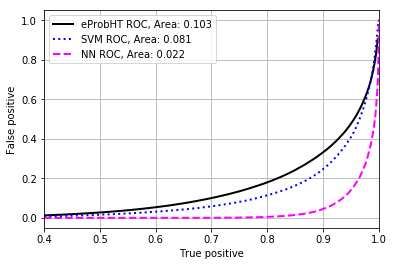

In [27]:
all_models = []
all_models.append(roc_eprob)
all_models.append(roc_svm1)
all_models.append(roc_model_default)
all_models.append(roc_model_wide)
all_models.append(roc_model_deep)

plot_roc(all_models, plots_path)

roc_model_default_clean = list(roc_model_default)
roc_model_default_clean[2] = 'NN'
roc_model_default_clean[3] += '_clean'
plot_roc([roc_eprob, roc_svm1, roc_model_default_clean], plots_path)

In [28]:
print("Total elapsed time: %s" % (strfdelta(datetime.now()-time_all_start, "{hours} hours, {minutes} minutes, {seconds} seconds")))

Total elapsed time: 0 hours, 42 minutes, 11 seconds
